# Controller Tuning Rules

Demonstrate the contruction of a Bode Plot using the  [Python Control Systems Library](https://github.com/python-control/python-control).  

### Open-Loop Transfer Function

Given a transfer function with time delay

$$G_p(s) = \frac{0.2 e^{-0.25s}}{s^2 + 1.5 s + 1}$$

the task is to construct a Bode plot.

The Python Control Systems Library does not provide a specific representation for time delay. It does, however, provide a function `pade` for creating Pade approximations to time delay systems.

In [107]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from control.matlab import *

(num_delay,den_delay) = pade(0.25,3)

Gp = tf([0.2],[1, 1.5, 1])*tf(num_delay,den_delay)
Gp


            -0.2 s^3 + 9.6 s^2 - 192 s + 1536
---------------------------------------------------------
s^5 + 49.5 s^4 + 1033 s^3 + 9168 s^2 + 1.248e+04 s + 7680

### Finding Cross-Over Frequency and Gain at Cross-Over

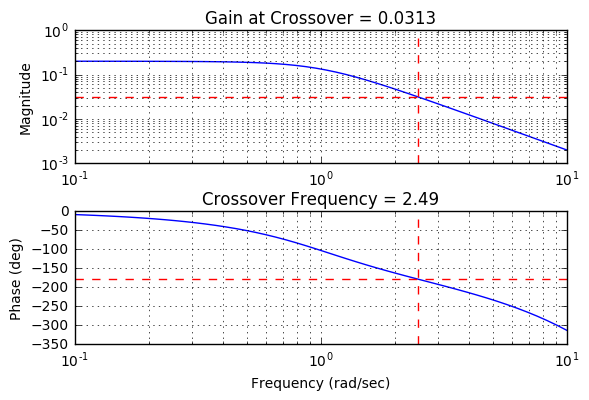

In [108]:
w = np.logspace(-1,1)
mag,phase,omega = bode(Gp,w)
plt.tight_layout()

# find the cross-over frequency and gain at cross-over
wc = np.interp(-180.0,np.flipud(phase),np.flipud(omega))
gc = np.interp(wc,omega,mag)

# get the subplots axes
ax1,ax2 = plt.gcf().axes

# add features to the magnitude plot
plt.sca(ax1)
plt.plot([omega[0],omega[-1]],[gc,gc],'r--')
[gmin,gmax] = plt.ylim()
plt.plot([wc,wc],[gmin,gmax],'r--')
plt.title("Gain at Crossover = {0:.3g}".format(gc))

# add features to the phase plot
plt.sca(ax2)
plt.plot([omega[0],omega[-1]],[-180,-180],'r--')
[pmin,pmax] = plt.ylim()
plt.plot([wc,wc],[pmin,pmax],'r--')
plt.title("Crossover Frequency = {0:.3g}".format(wc))

### Computing Ultimate Gain and Period

The conventional tuning rules for process control are written in terms of an ultimate gain $K_{cu}$ and ultimate period $P_u$. These are the values obtained by an experiment or calculation where the gain of a proportional only controller is increased until a steady closed-loop oscillation is first observed. The corresponding proportional gain is $K_{cu}$, and the period of oscillation is $P_u$.

These values may be computed from a Bode plot. The ultimate period corresponds to

$$P_u = \frac{2\pi}{\omega_c}$$

where $\omega_c$ is the cross-over frequency. The ultimate gain is then

$$K_{cu} = \frac{1}{G_p(\omega_c)}$$

where $G_p(\omega_c)$ is the open-loop process gain at the cross-over frequency.

In [109]:
Kcu = 1.0/gc
Pu = 2.0*np.pi/wc

## Ziegler-Nichols Tuning Rules

In [115]:
Kp = 0.45*Kcu
tauI = Pu/1.2
tauD = 0

P = tf([1.0],[1.0])
I = tf([1.0],[1.0,0.0])
D = tf([1.0,0.0],[1.0])

Gc = Kp*(P + I/tauI + tauD*D)

### Closed-Loop Step Responses

In [124]:
t = np.linspace(0,20)

Hyd =  1/(1+Gp*Gc)
Hyr =  Gp*Gc/(1+Gp*Gc)
Hud = -Gc/(1+Gp*Gc)
Hur =  Gc/(1+Gp*Gc)

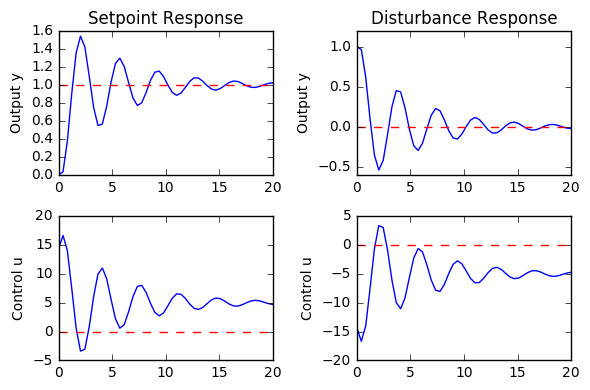

In [125]:
yr,t = step(Hyr,t)
plt.subplot(2,2,1)
plt.plot(t,yr)
plt.plot([np.min(t),np.max(t)],[1.0,1.0],'r--')
plt.title('Setpoint Response')
plt.ylabel('Output y')

yd,t = step(Hyd,t)
plt.subplot(2,2,2)
plt.plot(t,yd)
plt.plot([np.min(t),np.max(t)],[0.0,0.0],'r--')
plt.title('Disturbance Response')
plt.ylabel('Output y')

ur,t = step(Hur,t)
plt.subplot(2,2,3)
plt.plot(t,ur)
plt.plot([np.min(t),np.max(t)],[0.0,0.0],'r--')
plt.ylabel('Control u')

ud,t = step(Hud,t)
plt.subplot(2,2,4)
plt.plot(t,ud)
plt.plot([np.min(t),np.max(t)],[0.0,0.0],'r--')
plt.ylabel('Control u')

plt.tight_layout()